In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(device)

from utils import *

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

cuda:0


In [2]:
def load_model_and_data(p_model, p_data):
    annotations = torch.load(p_model)["annotations"]
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()
    
    input_dim = len(spc_names)
    hidden_dim = 2048
    latent_dim = 100
    model = VAE_2(input_dim, latent_dim, hidden_dim).to(device)
    model.load_state_dict(torch.load(p_model)["model"])
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model

### Evaluate reconstruction

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


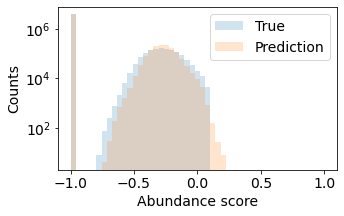

(5164857,) 5164857


In [3]:
p_model = "../models/160ksamples_trained_AE.pt"
p_data = "../data/160ksamples_filtered.pt"
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)

class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

# compare initial and reconstructed features
plt.figure(figsize=(5, 3))
plt.hist(y_test_scaled.numpy().flatten(), bins=np.linspace(-1, 1, 50), alpha=0.2, label="True")
all_recon = []
weights = [1.0, 1.0, 0.0]
for batch in test_DS:
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy().flatten()
    all_recon.extend(list(recon_x))
plt.hist(all_recon, bins=np.linspace(-1, 1, 50), alpha=0.2, label="Prediction")
plt.yscale("log")
plt.legend()
plt.xlabel("Abundance score")
plt.ylabel("Counts")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_distribution_{handle}.pdf", bbox_inches="tight")
plt.show()

print(y_test_scaled.numpy().flatten().shape, len(all_recon))

250it [00:01, 201.67it/s]


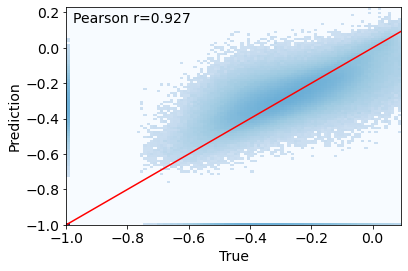

In [4]:
# check the reconstruction values
true_x_list = []
recon_x_list = []
n_batch_use = 1e3

for (idx, batch) in tqdm(enumerate(test_DS)):
    true_x = batch['Labels'].detach().numpy()
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy()
    true_x_list.append(true_x)
    recon_x_list.append(recon_x)
    if(idx>=n_batch_use):
        break
        
true_x_list = np.vstack(true_x_list)
recon_x_list = np.vstack(recon_x_list)
plt.figure(figsize=(6, 4))
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.ylabel("Prediction")
r, _ = stats.pearsonr(true_x_list.flatten(), recon_x_list.flatten())
plt.gca()
plt.text(0.02, 0.98, f'Pearson r={round(r, 3)}', transform=plt.gca().transAxes, va='top')

handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_fit_{handle}.pdf", bbox_inches="tight")
plt.show()

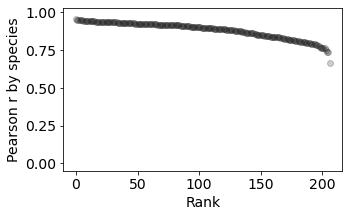

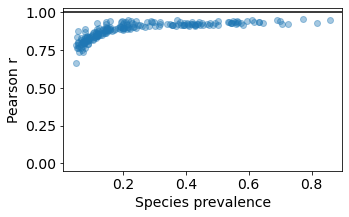

0.9576979290815557 Bacteria.Bacillota.Clostridia.Lachnospirales.Lachnospiraceae.Blautia
0.949710935082989 Bacteria.Bacillota.Clostridia.Oscillospirales.Ruminococcaceae.Faecalibacterium
0.9474621915457531 Bacteria.Bacteroidota.Bacteroidia.Bacteroidales.Rikenellaceae.Alistipes
0.9464919770821202 Bacteria.Bacillota.Clostridia.Christensenellales.Christensenellaceae.Incertae Sedis
0.946271422606325 Bacteria.Bacteroidota.Bacteroidia.Bacteroidales.Bacteroidaceae.Bacteroides
0.9456191152310504 Bacteria.Bacillota.Clostridia.Oscillospirales.Oscillospiraceae.Intestinimonas
0.9442139783093259 Bacteria.Bacillota.Bacilli.Staphylococcales.Gemellaceae.Gemella
0.943311081987698 Bacteria.Actinomycetota.Coriobacteriia.Coriobacteriales.Eggerthellaceae.Asaccharobacter
0.9432166793129225 Bacteria.Bacillota.Clostridia.Oscillospirales.Oscillospiraceae.UCG-002
0.943100253920663 Bacteria.Bacillota.Clostridia.Lachnospirales.Lachnospiraceae.NA
0.9424920564212587 Bacteria.Bacillota.Clostridia.Oscillospirales.Rumin

In [5]:
# Pearson r by species
coeffs = [ stats.pearsonr(true_x_list[:, i], recon_x_list[:, i]) for i in range(true_x_list.shape[1]) ]
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(5, 3))
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.xlabel("Rank")
plt.ylabel("Pearson r by species")
plt.ylim(-0.05, 1.03)
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_pearson_by_spc_{handle}.pdf", bbox_inches="tight")
plt.show()
    
# predictibility vs prevalence
X_all = torch.vstack([X_train_scaled, X_test_scaled]).numpy()
plt.figure(figsize=(5, 3))
plt.scatter([np.sum(X_all[:, i]>0)/X_all.shape[0] for i in range(X_all.shape[1])], \
             [i[0] for i in coeffs], alpha=0.4)
plt.xlabel("Species prevalence")
plt.ylabel("Pearson r")
plt.ylim(-0.05, 1.03)
plt.axhline(1.0, color="k")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_pearson_vs_prev_{handle}.pdf", bbox_inches="tight")
plt.show()

# top x best predicted species
spc_names = annotations["spcs"]
for i in range(20):
    print(coeffs_sorted[i][1][0], spc_names[coeffs_sorted[i][0]])

### Keystoneness, Invasiveness and interactions

In [6]:
'''
Flip a species's binary in the input and reconstruct the abundances. 
Compare it with the re-normalized abundance of other species. 
'''
# get parameter of data preprocessing so that we can transform back to relative abundance afterwards
def get_preprocess(p_data, p_model):
    _, _, _, _, annotations, model = load_model_and_data(p_model, p_data)
    train_indices = annotations["train_idx"]
    test_indices = annotations["test_idx"]
    
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names = torch.load(p_data)["names"]
    
    original_indices = np.arange(len(features))
    train_indices, test_indices = train_test_split(
        original_indices,
        test_size=0.2,
        random_state=42,
    )
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
#     print(y_test)

    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    
    return gmean_train, scaler

def preproc_inverse(abundance_scores, scaler, zero_thr=1e-8):
    before_scale = scaler.inverse_transform(abundance_scores)
    exp_vals = np.exp(before_scale)
    return exp_vals / (np.sum(exp_vals, axis=1, keepdims=True)+zero_thr)

In [8]:
from collections import defaultdict
from scipy.spatial.distance import braycurtis

p_model = "../models/160ksamples_trained_AE.pt"
p_data = "../data/160ksamples_filtered.pt"

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

gmean, scaler = get_preprocess(p_data, p_model)
model.eval()

VAE_2(
  (encoder): Sequential(
    (0): Linear(in_features=207, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (get_mu): Sequential(
    (0): Linear(in_features=2048, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (get_logvar): Sequential(
    (0): Linear(in_features=2048, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (decoder_b): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=207, bias=True)
    (4): Sigmoid()


In [11]:
# Keystoneness
num_species = X_test_scaled.shape[1]
keystone_distributions = defaultdict(list)

for batch in tqdm(train_DS):
    x = batch['Features'].to(device)
    with torch.no_grad():
        _, recon_orig, *_ = model(x)

    for i in range(x.shape[0]):
        x_i = x[i].clone()
        recon_i_scaled = recon_orig[i].cpu().numpy()
        if x_i.sum() == 0:
            continue  # skip samples with no microbes present
            
        present_indices = torch.nonzero(x_i).flatten()
        
        # get the "unperturbed" abundances for all possible 1->0 flips of this sample
        recon_i_scaled_all = np.tile(recon_i_scaled, (len(present_indices), 1))
        orig_relab_all = preproc_inverse(recon_i_scaled_all, scaler)
        for idx, j in enumerate(present_indices):
            renorm_orig_relab_all = orig_relab_all.copy()
            renorm_orig_relab_all[idx, j.item()] = 0.0
            renorm_orig_relab_all /= np.sum(renorm_orig_relab_all, axis=1, keepdims=True) 
            renorm_orig_relab_all += 1e-8
        # get the "perturbed" abundances for all possible 1->0 flips of this sample
        x_pert = torch.tile(x_i, (len(present_indices), 1))
        for idx, j in enumerate(present_indices):
            x_pert[idx, j.item()] = 0
        with torch.no_grad():
            _, recon_perturbed_scaled, *_ = model(x_pert)
        perturbed_relab_all = preproc_inverse(recon_perturbed_scaled.cpu().numpy(), scaler)
        
        # get the bray-curtis distances
        for idx, j in enumerate(present_indices):
            j = j.item()
            dist = braycurtis(renorm_orig_relab_all[idx], perturbed_relab_all[idx])
            keystone_distributions[j].append(dist)
            
# Compute average keystone score per species
keystone_scores = {
    i: np.mean(dists) for i, dists in keystone_distributions.items()
}

100%|██████████| 999/999 [19:35<00:00,  1.18s/it]


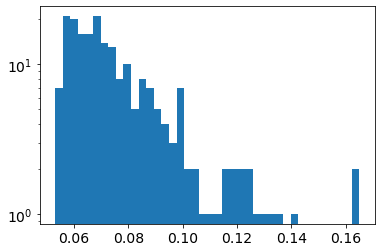

In [12]:
plt.hist(keystone_scores.values(), bins=40)
plt.yscale('log')

In [13]:
# Invasiveness
num_species = X_test_scaled.shape[1]
invader_distributions = defaultdict(list)

for batch in tqdm(train_DS):
    x = batch['Features'].to(device)
    with torch.no_grad():
        _, recon_orig, *_ = model(x)

    for i in range(x.shape[0]):
        x_i = x[i].clone()
        recon_i_scaled = recon_orig[i].cpu().numpy()
        if x_i.sum() == x_i.shape[0]:
            continue  # skip if all species are already present
            
        absent_indices = torch.nonzero(x_i == 0).flatten()
        
        # no need to renormalize "unperturbed" abundances this time
        recon_i_scaled_all = np.tile(recon_i_scaled, (len(absent_indices), 1))
        orig_relab_all = preproc_inverse(recon_i_scaled_all, scaler)
        renorm_orig_relab_all = orig_relab_all
        # get the "perturbed" abundances for all possible 0->1 flips of this sample
        x_pert = torch.tile(x_i, (len(absent_indices), 1))
        for idx, j in enumerate(absent_indices):
            x_pert[idx, j.item()] = 1
        with torch.no_grad():
            _, recon_perturbed_scaled, *_ = model(x_pert)
        perturbed_relab_all = preproc_inverse(recon_perturbed_scaled.cpu().numpy(), scaler)
        
        # get the bray-curtis distances
        for idx, j in enumerate(absent_indices):
            j = j.item()
            dist = braycurtis(renorm_orig_relab_all[idx], perturbed_relab_all[idx])
            invader_distributions[j].append(dist)
            
# Compute average invader score per species
invader_scores = {
    i: np.mean(dists) for i, dists in invader_distributions.items()
}

100%|██████████| 999/999 [33:31<00:00,  2.01s/it]


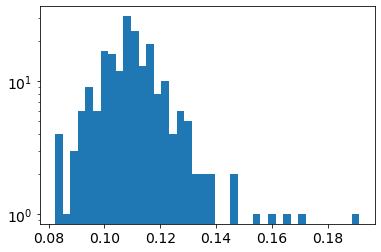

In [15]:
plt.hist(invader_scores.values(), bins=40)
plt.yscale('log')